# Value fn RMSE, random chain
Today: December 29, 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


## Import files
**Assumes one big .csv file with all experiments**

In [2]:
in_path = '/Users/anthony/Playground/tensorboard_logs/sr_return/1228_exps_3agents/exp1_rwalk_3agents/small_progress.csv'
pd_df_sep = '\|\|'

In_df = pd.read_csv(in_path, sep=pd_df_sep)
print(len(In_df))
In_df[0:3]

/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


336600


,"2020-12-28 17:12:33,558",num_episodes,envCls_name,agentCls_name,seed,gamma,lr,lamb,use_true_R_fn,episode_idx,total_steps,cumulative_reward,v_fn_rmse,sf_G_rmse,value_loss_avg,reward_loss_avg,sf_loss_avg,et_loss_avg
0,"2020-12-28 17:12:33,582",400,RandomWalkChainEnv,SarsaLambdaAgent,2,1.0,0.001,0.0,False,0,160,1.0,0.584445,None,0.006250,None,None,None
1,"2020-12-28 17:12:33,585",400,RandomWalkChainEnv,SarsaLambdaAgent,2,1.0,0.001,0.0,False,1,28,0.0,0.584445,None,0.000000,None,None,None
2,"2020-12-28 17:12:33,589",400,RandomWalkChainEnv,SarsaLambdaAgent,2,1.0,0.001,0.0,False,2,68,1.0,0.584368,None,0.014677,None,None,None


## Plot value fn RMSE
(At fixed number of learning steps)

### Parameter sweep script

0 SarsaLambdaAgent
1 ExpectedTraceAgent
2 SFReturnAgent


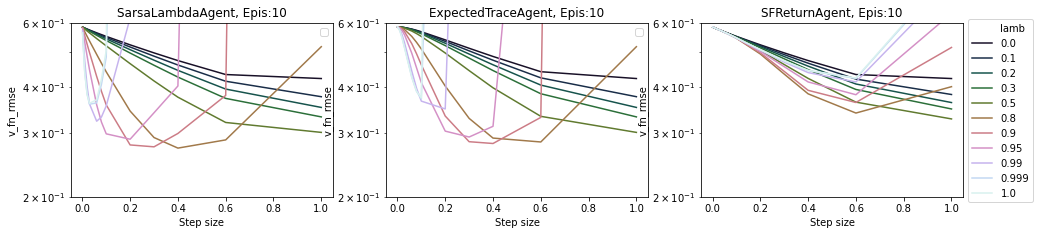

In [39]:
def script_plot_value_fn_rmse_episode(df, n_episode_idx, xscale='linear'):
    cur_plot_x = 'lr'
    cur_plot_hue = 'lamb'
    cur_plot_ci = None #'sd', None
    
    indep_subplot_col = 'agentCls_name'
    
    # == 
    # Set up the independent variables for the subplots
    
    # Get value set over indep col
    indep_val_set = list(set(df[indep_subplot_col]))
    indep_val_set = ['SarsaLambdaAgent', 
                     'ExpectedTraceAgent', 
                     'SFReturnAgent']  # NOTE: overwriting the ordering
    
    # Get the y-axis to plot, needs to be same length as indep_val_set
    cur_plot_y_list = ['v_fn_rmse', 
                       'v_fn_rmse', 
                       'v_fn_rmse']  # can also be sf_G_rmse
    
    # ==
    # Figure and Palette 
    plt.figure(figsize=(16, 3.2))
    
    n_hues = len(set(df[cur_plot_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues)
    
    # ==
    # Subplots
    for i, cur_indep_col in enumerate(indep_val_set):
        print(i, cur_indep_col)
        # ==
        # Filter for the dataframe
        # Filter for the right indep_subplot_col (usually agent type)
        sub_df = df[df[indep_subplot_col]==cur_indep_col]
        # Filter for the episode index
        cur_df = sub_df.copy(deep=True)
        cur_df = cur_df[cur_df['episode_idx'] == n_episode_idx] 
        cur_df['lamb'] = [round(e, 3) for e in cur_df['lamb']]  # float rounding
        
        # ==
        # Plot
        cur_plot_y = cur_plot_y_list[i]
        
        plt.subplot(1, len(indep_val_set), (i+1))
        sns.lineplot(x=cur_plot_x, y=cur_plot_y, 
                     hue=cur_plot_hue, 
                     ci=cur_plot_ci, 
                     palette = c_palette,
                     data=cur_df)

        plt.ylim([2e-1, 6e-1])
        plt.ylabel(cur_plot_y)
        plt.xlabel('Step size')
        plt.yscale('log')
        plt.xscale(xscale)
        plt.title(f'{cur_indep_col}, Epis:{n_episode_idx+1}')
        
        if i < (len(indep_val_set)-1):
            plt.legend([])  # assume same hues for legends
        else:
            plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')
            
    
script_plot_value_fn_rmse_episode(In_df, 9)

0 SarsaLambdaAgent
1 ExpectedTraceAgent
2 SFReturnAgent


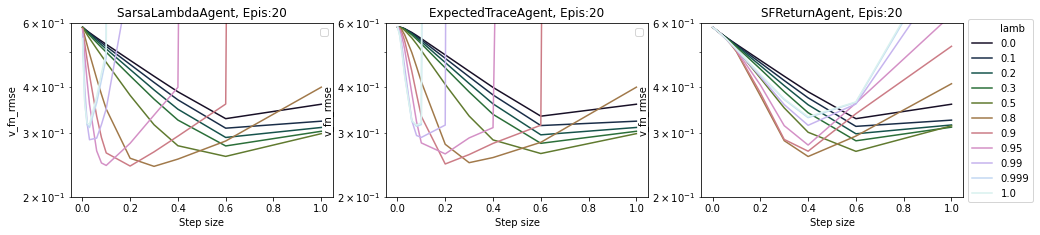

In [40]:
script_plot_value_fn_rmse_episode(In_df, 19, xscale='linear')

0 SarsaLambdaAgent
1 ExpectedTraceAgent
2 SFReturnAgent


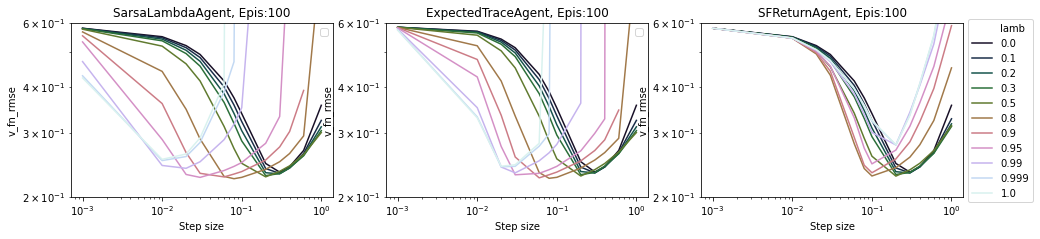

In [41]:
script_plot_value_fn_rmse_episode(In_df, 99, xscale='log')

0 SarsaLambdaAgent
1 ExpectedTraceAgent
2 SFReturnAgent


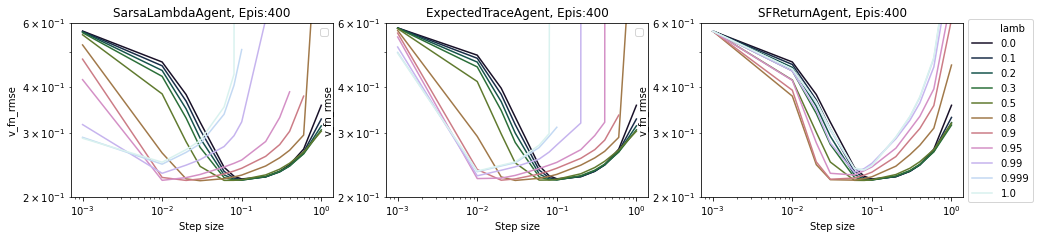

In [42]:
script_plot_value_fn_rmse_episode(In_df, 399, xscale='log')

## Error over time plot 
For fixed stepsize

In [44]:
sorted(list(set(In_df['lr'])))

[0.001, 0.01, 0.02, 0.03, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.6, 1.0]

Find the best performing parameters for a given episode idx

In [70]:
def script_find_min_value_error(df, n_episode_idx):
    indep_subplot_col = 'agentCls_name'
    indep_val_set = list(set(df[indep_subplot_col]))
    
    sub_df = df[df['episode_idx']==n_episode_idx]
    
    for i, cur_indep_col in enumerate(indep_val_set):
        cur_df = sub_df[sub_df[indep_subplot_col]==cur_indep_col]
        cur_df['lamb'] = [round(e, 3) for e in cur_df['lamb']]  # float rounding
        cur_df = cur_df.copy(deep=True)
        
        avgErr_df = cur_df.groupby(['lamb', 'lr']).mean()
        best_row = avgErr_df['v_fn_rmse'].idxmin()
        
        print(f'{i}, {cur_indep_col}, lamb:{best_row[0]}, lr:{best_row[1]}')
        
script_find_min_value_error(In_df, 399)

0, SFReturnAgent, lamb:0.5, lr:0.08
1, ExpectedTraceAgent, lamb:0.8, lr:0.03
2, SarsaLambdaAgent, lamb:0.8, lr:0.03


/Users/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


**Plot best parameters**

0 SarsaLambdaAgent
1 ExpectedTraceAgent
2 SFReturnAgent


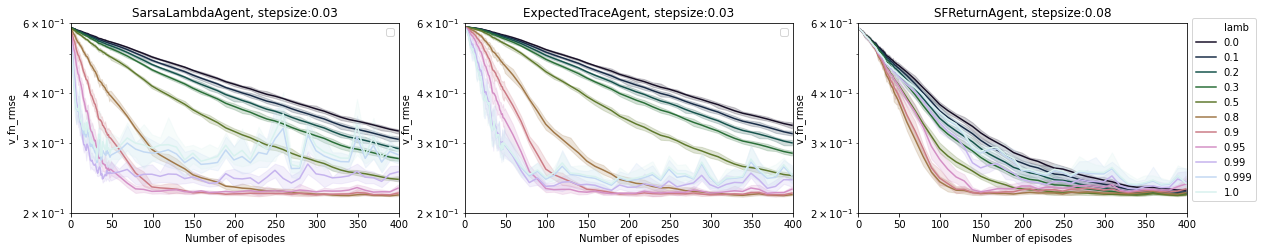

In [72]:
def script_plot_value_learning_per_episode(df, lr):
    cur_plot_x = 'episode_idx'
    cur_plot_hue = 'lamb'
    cur_plot_ci = 95  # 'sd', 95, None
    cur_plot_n_boot = 20
    
    indep_subplot_col = 'agentCls_name'
    
    # == 
    # Set up the independent variables for the subplots
    
    # Get value set over indep col
    indep_val_set = list(set(df[indep_subplot_col]))
    indep_val_set = ['SarsaLambdaAgent', 
                     'ExpectedTraceAgent', 
                     'SFReturnAgent']  # NOTE: overwriting the ordering
    
    # Get the y-axis to plot, needs to be same length as indep_val_set
    cur_plot_y_list = ['v_fn_rmse', 
                       'v_fn_rmse', 
                       'v_fn_rmse']  # can also be sf_G_rmse
    cur_lr_list = [0.03, 0.03, 0.08]
    
    # ==
    # Figure and Palette 
    plt.figure(figsize=(20, 3.5))
    
    n_hues = len(set(df[cur_plot_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues)
    
    # ==
    # Subplots
    for i, cur_indep_col in enumerate(indep_val_set):
        cur_stepsize = cur_lr_list[i]
        cur_plot_y = cur_plot_y_list[i]
        print(i, cur_indep_col)
        # ==
        # Filter for the dataframe
        # Filter for the right indep_subplot_col (usually agent type)
        sub_df = df[df[indep_subplot_col]==cur_indep_col]
        # Filter for the episode index
        cur_df = sub_df.copy(deep=True)
        cur_df = cur_df[cur_df['lr'] == cur_stepsize] 
        cur_df['lamb'] = [round(e, 3) for e in cur_df['lamb']]  # float rounding
        
        # 
        plt.subplot(1, len(indep_val_set), (i+1))
        sns.lineplot(x=cur_plot_x, y=cur_plot_y, 
                     hue=cur_plot_hue, 
                     ci=cur_plot_ci, 
                     n_boot=cur_plot_n_boot,
                     palette = c_palette,
                     data=cur_df)
        
        plt.ylim([2e-1, 6e-1])
        plt.xlim([0, 400])
        plt.yscale('log')
        
        plt.xlabel('Number of episodes')
        plt.ylabel(cur_plot_y)
        plt.title(f'{cur_indep_col}, stepsize:{cur_stepsize}')
        
        if i < (len(indep_val_set)-1):
            plt.legend([])  # assume same hues for legends
        else:
            plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')
        
    plt.show()
    
    
script_plot_value_learning_per_episode(In_df, lr=0.1)

## Looking at different losses

In [108]:
def script_plot_sf_losses_per_episode(df, agentCls_name, lr, plot_y_list):
    cur_plot_x = 'episode_idx'
    cur_plot_hue = 'lamb'
    cur_plot_ci = 'sd'  # 'sd', 95, None
    cur_plot_n_boot = 20
    
    cur_plot_y_list = plot_y_list
    cur_stepsize = lr
    
    # Filter for df
    cur_df = df[df['agentCls_name']==agentCls_name]
    cur_df = cur_df[cur_df['lr'] == cur_stepsize]
    cur_df['lamb'] = [round(e, 3) for e in cur_df['lamb']]  # float rounding
    
    # == 
    # Figure and palette
    plt.figure(figsize=(15, 3.2))
    n_hues = len(set(cur_df[cur_plot_hue].values))
    c_palette = sns.color_palette("cubehelix", n_hues)
    
    # Make sure type is correct
    for e in cur_plot_y_list:
        cur_df[e] = cur_df[e].astype(float)
    
    for i in range(len(cur_plot_y_list)):
        cur_plot_y = cur_plot_y_list[i]
        
        # 
        plt.subplot(1, len(cur_plot_y_list), (i+1))
        sns.lineplot(x=cur_plot_x, y=cur_plot_y, 
                     hue=cur_plot_hue, 
                     ci=cur_plot_ci,
                     n_boot=cur_plot_n_boot,
                     palette = c_palette,
                     data=cur_df)
        
        #plt.ylim([0.7, 100])
        #plt.yscale('log')
        plt.xlim([0, 200])
        
        plt.xlabel('Number of episodes')
        plt.ylabel('Value function RMSE')
        plt.title(f'Loss: {cur_plot_y}')
        
        if i < (len(cur_plot_y_list)-1):
            plt.legend([])  # assume same hues for legends
        else:
            plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')  

SF losses

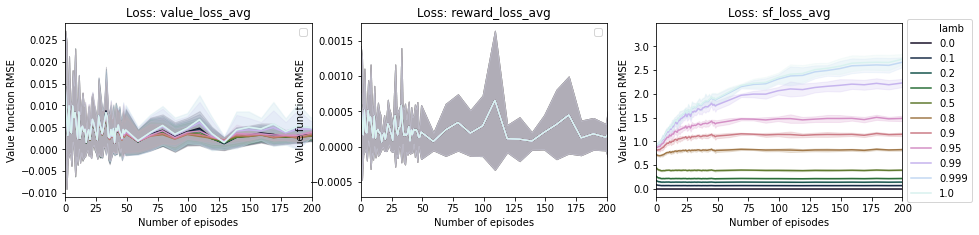

In [109]:
script_plot_sf_losses_per_episode(
    In_df, agentCls_name='SFReturnAgent', 
    lr=0.08, 
    plot_y_list=['value_loss_avg','reward_loss_avg','sf_loss_avg']
)
plt.show()

TD(lambda) losses

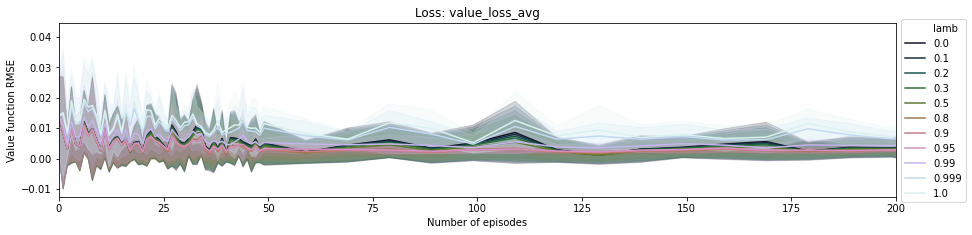

In [106]:
script_plot_sf_losses_per_episode(
    In_df, agentCls_name='SarsaLambdaAgent', 
    lr=0.03, 
    plot_y_list=['value_loss_avg']
)
#plt.ylim([1e-3,1e-1])
#plt.yscale('log')
plt.show()

Expected Trace Losses

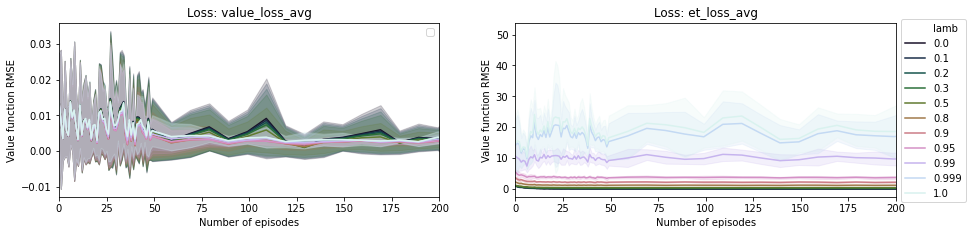

In [107]:
script_plot_sf_losses_per_episode(
    In_df, agentCls_name='ExpectedTraceAgent', 
    lr=0.03, 
    plot_y_list=['value_loss_avg', 'et_loss_avg']
)

#plt.yscale('log')
#plt.ylim(1e-3, 50)
plt.show()